In [1]:
import math
import random

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [8]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) *(5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
bnmean_running = torch.ones(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)

parameters = [C, W1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [72]:
hpreact.shape

torch.Size([32, 200])

In [73]:
nums = torch.tensor([np.arange(9)]).view(3, 3).float()
nums

tensor([[0., 1., 2.],
        [3., 4., 5.],
        [6., 7., 8.]])

In [74]:
nums.mean(0, keepdims=True)

tensor([[3., 4., 5.]])

In [75]:
hpreact.mean(0, keepdims=True).shape

torch.Size([1, 200])

In [76]:
hpreact.std(0, keepdims=True).shape

torch.Size([1, 200])

In [9]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  
  bnmeani = hpreact.mean(0, keepdims=True)
  bnstdi = hpreact.std(0, keepdims=True)
  hpreact = bngain * (hpreact - bnmeani)/bnstdi + bnbias
  
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None

  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  


      0/ 200000: 3.3014
  10000/ 200000: 2.4789
  20000/ 200000: 2.3364
  30000/ 200000: 2.1072
  40000/ 200000: 2.0523
  50000/ 200000: 2.4329
  60000/ 200000: 2.2905
  70000/ 200000: 2.0826
  80000/ 200000: 2.0123
  90000/ 200000: 2.0183
 100000/ 200000: 2.4473
 110000/ 200000: 2.0486
 120000/ 200000: 2.1925
 130000/ 200000: 2.3583
 140000/ 200000: 2.2693
 150000/ 200000: 2.3672
 160000/ 200000: 2.0888
 170000/ 200000: 2.0872
 180000/ 200000: 2.4111
 190000/ 200000: 1.8808


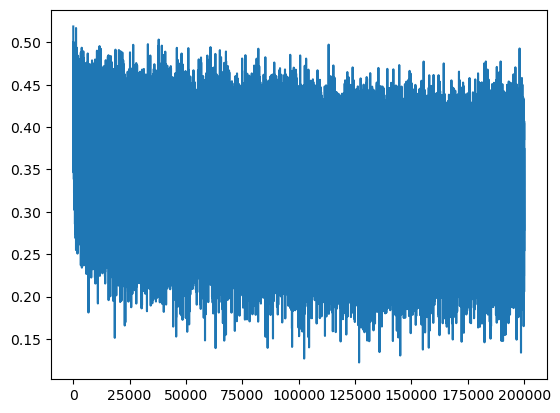

In [13]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean = hpreact.mean(0, keepdims=True)
  bnstd = hpreact.std(0, keepdims=True)

In [10]:
bnmean_running

tensor([[-2.1052,  0.5062, -1.0491,  1.1578,  0.6408,  0.3288,  1.9093, -0.4267,
          0.7898,  2.1971, -2.5673, -2.1398, -0.5380, -0.8096, -0.5738, -0.7688,
          0.3398, -1.7605, -0.5851,  1.5558, -0.5555, -0.2153, -0.3660,  0.2812,
          1.2576,  1.7618,  1.3153,  0.3318,  1.0108,  1.6235, -0.6543, -0.9489,
          0.7128, -0.2062,  0.4278, -0.9170, -1.5013,  0.2250,  0.0677,  0.9039,
          0.1809, -0.9840, -0.5668, -0.1117,  0.8465,  0.2390,  0.9985, -1.4425,
          2.0987,  1.2389,  1.4190,  0.1478,  2.2976,  0.7490,  0.9491, -2.4884,
         -0.3599,  0.7966,  2.2169, -1.4949, -0.2631,  0.9898,  0.8070,  0.4637,
          1.2417,  1.3894, -0.2368,  1.4214, -0.5096, -0.2794,  0.0982,  0.5819,
          0.6432, -1.8995, -2.3053,  0.4097,  1.2177, -0.1014,  0.2751,  0.4427,
         -0.2150,  1.2323,  1.2708,  1.0634,  0.3814, -0.6506, -0.8102, -0.0687,
          2.7042, -0.2174, -0.9457,  1.2814, -0.9254, -1.0830, -1.5526,  0.5789,
         -0.1294, -0.3462, -

In [15]:
bnmean

tensor([[-2.1171,  0.5151, -1.0355,  1.1472,  0.6457,  0.3297,  1.8942, -0.4451,
          0.7888,  2.1818, -2.5897, -2.1385, -0.5529, -0.8029, -0.5847, -0.7732,
          0.3468, -1.7540, -0.5939,  1.5619, -0.5667, -0.2291, -0.3648,  0.2870,
          1.2614,  1.7647,  1.3128,  0.3417,  1.0104,  1.6196, -0.6550, -0.9392,
          0.7127, -0.2060,  0.4415, -0.9259, -1.5156,  0.2045,  0.0871,  0.9062,
          0.1703, -1.0021, -0.5580, -0.1233,  0.8608,  0.2528,  0.9942, -1.4480,
          2.0848,  1.2254,  1.4297,  0.1473,  2.2827,  0.7296,  0.9589, -2.5080,
         -0.3612,  0.7973,  2.2360, -1.4968, -0.2657,  0.9916,  0.8040,  0.4386,
          1.2355,  1.3860, -0.2402,  1.4185, -0.5125, -0.2784,  0.0867,  0.6063,
          0.6206, -1.8871, -2.3069,  0.4171,  1.2391, -0.0953,  0.2780,  0.4433,
         -0.2146,  1.2355,  1.2541,  1.0807,  0.3931, -0.6237, -0.8048, -0.0700,
          2.7138, -0.2097, -0.9276,  1.2881, -0.9340, -1.0924, -1.5613,  0.5643,
         -0.1310, -0.3506, -

In [14]:
@torch.no_grad()
def split_loss(split):
  x, y = {'train': (Xtr, Ytr),
          'val': (Xdev, Ydev),
          'test': (Xte, Yte)
          }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 +b1
  hpreact = bngain * (hpreact - bnmean)/bnstd + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())
  
split_loss('train')
split_loss('val')
  

train 2.065701723098755
val 2.110726833343506


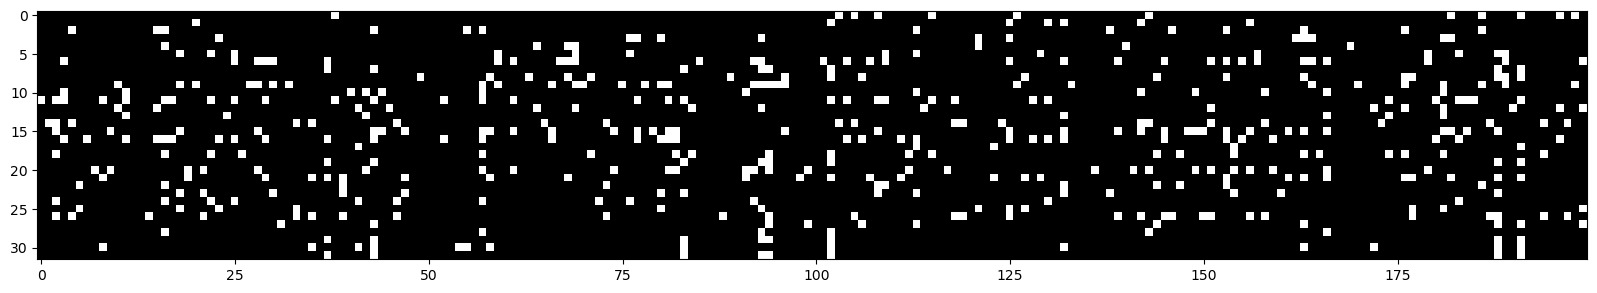

In [49]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

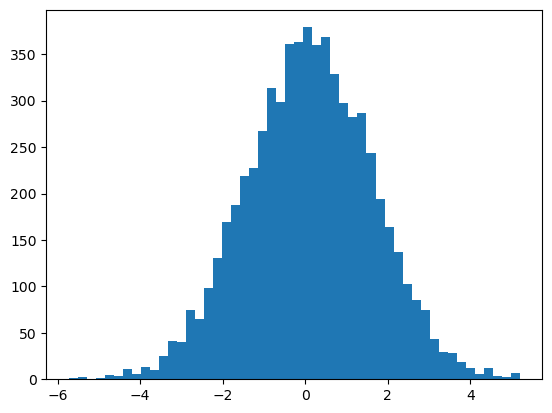

In [50]:
plt.hist(hpreact.view(-1).tolist(), 50);

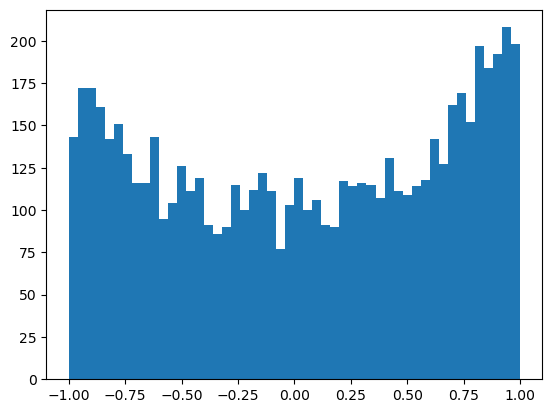

In [45]:
plt.hist(h.view(-1).tolist(), 50); # Why is this a problem? hint: derivative of tanh